# Predicting Hypoxic Ischemic Encephalopathy from Collaborative Perinatal Project using ML

In [1]:
# upgrade tensorflow
! pip install grpcio==1.24.3
! pip install tensorflow==2.0.0

# Load the TensorBoard notebook extension
%load_ext tensorboard

import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from sklearn.metrics import brier_score_loss, roc_curve, auc
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="white")

     |████████████████████████████████| 2.2MB 9.9MB/s eta 0:00:01
  Found existing installation: grpcio 1.23.0
    Uninstalling grpcio-1.23.0:
      Successfully uninstalled grpcio-1.23.0
     |████████████████████████████████| 86.3MB 579kB/s  eta 0:00:01
     |████████████████████████████████| 71kB 14.8MB/s eta 0:00:01
     |████████████████████████████████| 450kB 29.2MB/s eta 0:00:01
     |████████████████████████████████| 3.8MB 27.4MB/s eta 0:00:01
     |████████████████████████████████| 61kB 15.6MB/s eta 0:00:01
     |████████████████████████████████| 81kB 25.4MB/s eta 0:00:01
     |████████████████████████████████| 133kB 31.3MB/s eta 0:00:01
     |████████████████████████████████| 81kB 18.6MB/s eta 0:00:01
  Created wheel for opt-einsum: filename=opt_einsum-3.1.0-cp37-none-any.whl size=61681 sha256=42536c2e5d8522e292ba453feb43c4579c04c7ae1dd335b1a83a9a0049a5cd19
  Stored in directory: /home/jovyan/.cache/pip/wheels/2c/b1/94/43d03e130b929aae7ba3f8d15cbd7bc0d1cb5bb38a5c721833
  Crea

In [2]:
def get_feature_importance(pred, out):
    # fit RF with all variables using five-fold CV
    clf = RandomForestClassifier(random_state=0, n_estimators=100)
    scores = cross_val_score(clf, pred.to_numpy(), out.to_numpy(), cv=5, scoring='roc_auc')
    
    # get feature importance measures
    clf.fit(pred, out.to_numpy())
    fi = pd.DataFrame(data={'predictor' : pred.columns, 'feature_importance': clf.feature_importances_})
    
    return fi

In [3]:
def fit(clf, x_train, y_train, x_test, y_test):   
    # train model
    clf.fit(x_train, y_train)
    
    # calculate probabilities for test data
    y_test_pred = clf.predict_proba(x_test)[:, 1]
    
    # calculate roc auc metric
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    roc_auc = auc(fpr, tpr)
    
    # calculate brier loss for probability accuracy
    brier_loss = brier_score_loss(y_test, y_test_pred)
    
    print("ROC AUC: {}\nBrier loss: {}".format(np.round(roc_auc, 3), np.round(brier_loss, 3)))
    
    return y_test_pred

In [4]:
def fit_nn(model, x_train, y_train, x_test, y_test):
    print("x_train n={} y_train n={} x_test n={} y_test n={}".format(len(x_train), len(y_train), len(x_test), len(y_test)))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
    
    # train model
    model.fit(tf.convert_to_tensor(x_train.to_numpy(), np.float32), tf.convert_to_tensor(y_train.to_numpy(), np.float32), epochs=30)
    
    # predict test probabilities
    y_test_pred = model.predict(tf.convert_to_tensor(x_test.to_numpy(), np.float32))
    
    # calculate roc auc metric
    fpr, tpr, thresholds = roc_curve(y_test.to_numpy(), y_test_pred)
    roc_auc = auc(fpr, tpr)
    
    # calculate brier loss for probability accuracy
    brier_loss = brier_score_loss(y_test.to_numpy(), y_test_pred)
    
    print("ROC AUC: {}\nBrier loss: {}".format(np.round(roc_auc, 3), np.round(brier_loss, 3)))
    
    return y_test_pred

In [5]:
def recursive_feature_elimination_rf(train_x, train_y, test_x, test_y):
    estimator = RandomForestClassifier(random_state=0, n_estimators=100)
    selector = RFE(estimator, 25, step=1)
    selector = selector.fit(train_x.to_numpy(), train_y.to_numpy())
    return train_x[train_x.columns[selector.support_]], train_y, test_x[train_x.columns[selector.support_]], test_y

In [6]:
def process_data(df, numeric_features, means, stds):
    
    # normalise continuous variables
    for i, f in enumerate(numeric_features):
        if f in df.columns:
            df[f] = (df[f] - means[i]) / stds[i]
        
    return df

## Read in data
The first(A) is one with all variables with >5% missing values removed, the second(B) is imputed form the most recent complete data-point prior to that birth and the third(C) is imputed using mode values

Derived variables are:
- _cohort – Either 1 (born in the first deriving cohort) or 0 (in the second, testing cohort)
- _hie – 1 for HIE, 0 for not
- _id
- _lapgar – 1 for a low Apgar score, 0 for not
- _ne – Another measure of brain injury (not used at present)
- _neonataldeath – Not used at present
- _perinataldeath – 1 for perinatal death; 0 for not
- _resus – 1 for resus at birth, and 0 for not
- _stillborn – Not used at present
- _yearofbirth -  Year of birth

First letter is either a (antenatal), g (growth) or I (intrapartum) variable
Second letter is type of entry; c (categorical), o(ordinal) or l(linear)
Then _NAME (most have one given)
Then _#### - number of were extraction was performed on the [Variable File]("3. Index_Variable File_304.2ADV3A.pdf")

In [7]:
# read in data from DO
dat = pd.read_stata("data/1_2_3_4A._Done.dta")

In [8]:
# sep cols
antenatal = []
antenatal_growth = []
antenatal_intrapartum = []
categorical = []
ordinal = []
linear = []

for col in dat.columns:
    if col[0] == "_":
        continue
    if col[0] == "a":
        antenatal.append(col)
        antenatal_growth.append(col)
        antenatal_intrapartum.append(col)
    if col[0] == "g":
        antenatal_growth.append(col)
    if col[0] == "i":
        antenatal_intrapartum.append(col)
    if col[1] == "c":
        categorical.append(col)
    if col[1] == "o":
        ordinal.append(col)
    if col[1] == "l":
        linear.append(col)

In [9]:
# set fields correctly
outcomes = ['_hie', '_lapgar', '_perinataldeath', '_resus']
dat[categorical] = dat[categorical].astype('category')
dat[outcomes] = dat[outcomes].astype('category')

In [10]:
# split test and train
test = dat[dat['_cohort'] == 0]
train = dat[dat['_cohort'] == 1]

## get mean and SD for **training** dataset to standardise variables (where needed)
desc = train[linear].describe()
means = np.array(desc.T['mean'])
stds = np.array(desc.T['std'])

def split_data(df, x_cols, y_col):
    x = df[x_cols + [y_col]]
    x = x.dropna(axis='index')
    y = x.pop(y_col)
    return x, y

## Models

All(?) we need from the ML model is one which takes the outcomes (HIE (Primary outcome), Low Apgar, Perinatal Death and Resus) and builds 3 prediction models. First is only antenatal variables (a*), then next is antenatal and growth (a* and g*) and then antenatal and intrapartum (a* and i*). From each model the idea to produce a prediction score from cohort 1, and apply to cohort 0, derive an ROC/AUC score for the prediction, creating a variable containing which deciles of risk the infant is placed in (1-10) – in order to compare with the other models being developed.

### Antenatal

#### HIE

##### Feature selection

In [11]:
# split out data
train_x, train_y = split_data(train, antenatal, '_hie')
test_x, test_y = split_data(test, antenatal, '_hie')

In [12]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

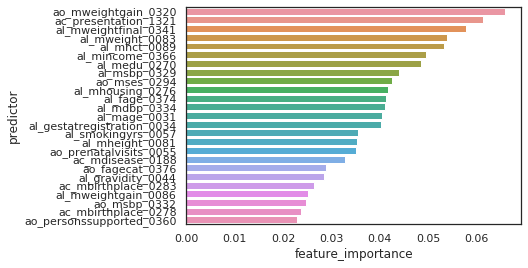

In [13]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [14]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.647
Brier loss: 0.005


##### Random forest

In [15]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.575
Brier loss: 0.005


##### Neural net

In [16]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [17]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6321 y_train n=6321 x_test n=9356 y_test n=9356
Train on 6321 samples
Epoch 1/30
6321/6321 [==============================] - 1s 178us/sample - loss: 0.0927 - AUC: 0.4600
Epoch 2/30
6321/6321 [==============================] - 0s 68us/sample - loss: 0.0562 - AUC: 0.5082
Epoch 3/30
6321/6321 [==============================] - 0s 71us/sample - loss: 0.0657 - AUC: 0.4997
Epoch 4/30
6321/6321 [==============================] - 0s 67us/sample - loss: 0.0556 - AUC: 0.5406
Epoch 5/30
6321/6321 [==============================] - 0s 68us/sample - loss: 0.0547 - AUC: 0.6036
Epoch 6/30
6321/6321 [==============================] - 0s 65us/sample - loss: 0.0580 - AUC: 0.6017
Epoch 7/30
6321/6321 [==============================] - 0s 63us/sample - loss: 0.0525 - AUC: 0.6076
Epoch 8/30
6321/6321 [==============================] - 0s 65us/sample - loss: 0.0470 - AUC: 0.6922
Epoch 9/30
6321/6321 [==============================] - 0s 67us/sample - loss: 0.0533 - AUC: 0.6968
Epoch 10/30
6321/63

## Perinatal Death

##### Feature selection

In [18]:
# split out data
train_x, train_y = split_data(train, antenatal, '_perinataldeath')
test_x, test_y = split_data(test, antenatal, '_perinataldeath')

In [19]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

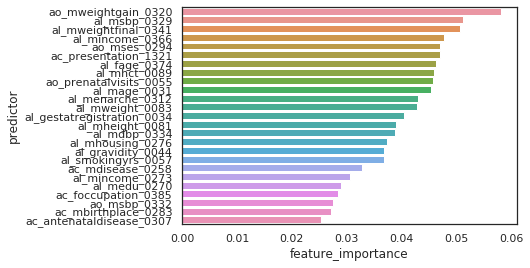

In [20]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [21]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.661
Brier loss: 0.007


##### Random forest

In [22]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.58
Brier loss: 0.007


##### Neural net

In [23]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [24]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6362 y_train n=6362 x_test n=9395 y_test n=9395
Train on 6362 samples
Epoch 1/30
6362/6362 [==============================] - 1s 127us/sample - loss: 1.1764 - AUC: 0.4968
Epoch 2/30
6362/6362 [==============================] - 0s 69us/sample - loss: 0.0692 - AUC: 0.4863
Epoch 3/30
6362/6362 [==============================] - 0s 62us/sample - loss: 0.0484 - AUC: 0.5313
Epoch 4/30
6362/6362 [==============================] - 0s 67us/sample - loss: 0.0475 - AUC: 0.5686
Epoch 5/30
6362/6362 [==============================] - 0s 64us/sample - loss: 0.0461 - AUC: 0.5311
Epoch 6/30
6362/6362 [==============================] - 0s 67us/sample - loss: 0.0443 - AUC: 0.5730
Epoch 7/30
6362/6362 [==============================] - 0s 67us/sample - loss: 0.0453 - AUC: 0.6157
Epoch 8/30
6362/6362 [==============================] - 0s 66us/sample - loss: 0.0424 - AUC: 0.6652
Epoch 9/30
6362/6362 [==============================] - 0s 67us/sample - loss: 0.0449 - AUC: 0.5965
Epoch 10/30
6362/63

## Low Apgar

##### Feature selection

In [25]:
# split out data
train_x, train_y = split_data(train, antenatal, '_lapgar')
test_x, test_y = split_data(test, antenatal, '_lapgar')

In [26]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

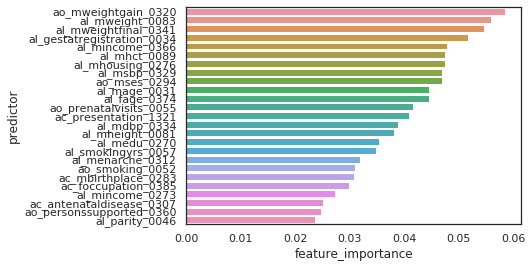

In [27]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [28]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.636
Brier loss: 0.026


##### Random forest

In [29]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.595
Brier loss: 0.028


##### Neural net

In [30]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [31]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6333 y_train n=6333 x_test n=9378 y_test n=9378
Train on 6333 samples
Epoch 1/30
6333/6333 [==============================] - 1s 139us/sample - loss: 0.2645 - AUC: 0.5063
Epoch 2/30
6333/6333 [==============================] - 0s 62us/sample - loss: 0.1767 - AUC: 0.5471
Epoch 3/30
6333/6333 [==============================] - 0s 73us/sample - loss: 0.1655 - AUC: 0.5624
Epoch 4/30
6333/6333 [==============================] - 0s 71us/sample - loss: 0.1565 - AUC: 0.5753
Epoch 5/30
6333/6333 [==============================] - 0s 70us/sample - loss: 0.1594 - AUC: 0.5732
Epoch 6/30
6333/6333 [==============================] - 0s 69us/sample - loss: 0.1556 - AUC: 0.5964
Epoch 7/30
6333/6333 [==============================] - 0s 64us/sample - loss: 0.1518 - AUC: 0.6277
Epoch 8/30
6333/6333 [==============================] - 0s 68us/sample - loss: 0.1550 - AUC: 0.5947
Epoch 9/30
6333/6333 [==============================] - 0s 68us/sample - loss: 0.1478 - AUC: 0.6170
Epoch 10/30
6333/63

## Resus

##### Feature selection

In [32]:
# split out data
train_x, train_y = split_data(train, antenatal, '_resus')
test_x, test_y = split_data(test, antenatal, '_resus')

In [33]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

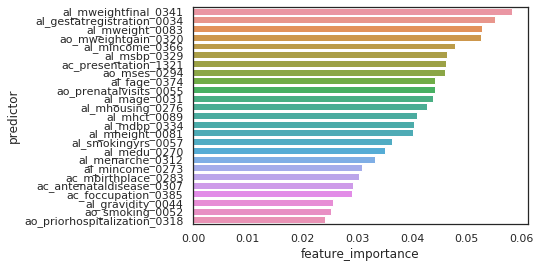

In [34]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [35]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.601
Brier loss: 0.052


##### Random forest

In [36]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.582
Brier loss: 0.054


##### Neural net

In [37]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [38]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6350 y_train n=6350 x_test n=9373 y_test n=9373
Train on 6350 samples
Epoch 1/30
6350/6350 [==============================] - 1s 138us/sample - loss: 0.4165 - AUC: 0.4708
Epoch 2/30
6350/6350 [==============================] - 0s 67us/sample - loss: 0.2268 - AUC: 0.5175
Epoch 3/30
6350/6350 [==============================] - 0s 64us/sample - loss: 0.2286 - AUC: 0.5238
Epoch 4/30
6350/6350 [==============================] - 0s 68us/sample - loss: 0.2184 - AUC: 0.5460
Epoch 5/30
6350/6350 [==============================] - 0s 69us/sample - loss: 0.2068 - AUC: 0.5857
Epoch 6/30
6350/6350 [==============================] - 0s 69us/sample - loss: 0.2066 - AUC: 0.5999
Epoch 7/30
6350/6350 [==============================] - 0s 74us/sample - loss: 0.2050 - AUC: 0.6186
Epoch 8/30
6350/6350 [==============================] - 0s 66us/sample - loss: 0.2063 - AUC: 0.6048
Epoch 9/30
6350/6350 [==============================] - 0s 64us/sample - loss: 0.2093 - AUC: 0.6218
Epoch 10/30
6350/63

### Antenatal and growth

##### Feature selection

In [39]:
# split out data
train_x, train_y = split_data(train, antenatal_growth, '_hie')
test_x, test_y = split_data(test, antenatal_growth, '_hie')

In [40]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

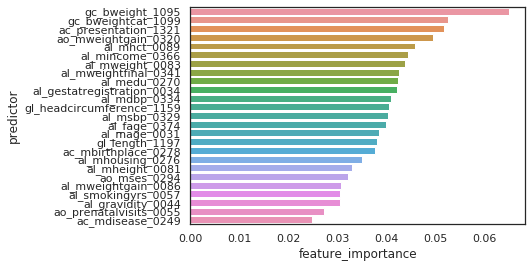

In [41]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [42]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.618
Brier loss: 0.004


##### Random forest

In [43]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.566
Brier loss: 0.004


##### Neural net

In [44]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [45]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6270 y_train n=6270 x_test n=9236 y_test n=9236
Train on 6270 samples
Epoch 1/30
6270/6270 [==============================] - 1s 137us/sample - loss: 22.9333 - AUC: 0.4841
Epoch 2/30
6270/6270 [==============================] - 0s 69us/sample - loss: 1.0631 - AUC: 0.5000
Epoch 3/30
6270/6270 [==============================] - 0s 67us/sample - loss: 0.1890 - AUC: 0.5160
Epoch 4/30
6270/6270 [==============================] - 0s 69us/sample - loss: 0.1066 - AUC: 0.5203
Epoch 5/30
6270/6270 [==============================] - 0s 66us/sample - loss: 0.0893 - AUC: 0.5539
Epoch 6/30
6270/6270 [==============================] - 0s 65us/sample - loss: 0.0981 - AUC: 0.5747
Epoch 7/30
6270/6270 [==============================] - 0s 66us/sample - loss: 0.1240 - AUC: 0.5183
Epoch 8/30
6270/6270 [==============================] - 0s 61us/sample - loss: 0.1021 - AUC: 0.5239
Epoch 9/30
6270/6270 [==============================] - 0s 65us/sample - loss: 0.1089 - AUC: 0.5172
Epoch 10/30
6270/6

## Perinatal Death

##### Feature selection

In [46]:
# split out data
train_x, train_y = split_data(train, antenatal_growth, '_perinataldeath')
test_x, test_y = split_data(test, antenatal_growth, '_perinataldeath')

In [47]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

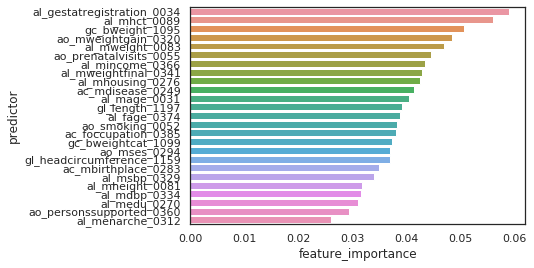

In [48]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [49]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.506
Brier loss: 0.003


##### Random forest

In [50]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.54
Brier loss: 0.003


##### Neural net

In [51]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [52]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6309 y_train n=6309 x_test n=9260 y_test n=9260
Train on 6309 samples
Epoch 1/30
6309/6309 [==============================] - 1s 138us/sample - loss: 3.7582 - AUC: 0.5094
Epoch 2/30
6309/6309 [==============================] - 0s 64us/sample - loss: 0.4843 - AUC: 0.5000
Epoch 3/30
6309/6309 [==============================] - 0s 68us/sample - loss: 0.0624 - AUC: 0.5021
Epoch 4/30
6309/6309 [==============================] - 0s 71us/sample - loss: 0.1057 - AUC: 0.5068
Epoch 5/30
6309/6309 [==============================] - 0s 68us/sample - loss: 0.0512 - AUC: 0.5977
Epoch 6/30
6309/6309 [==============================] - 0s 69us/sample - loss: 0.1359 - AUC: 0.5242
Epoch 7/30
6309/6309 [==============================] - 0s 63us/sample - loss: 0.0951 - AUC: 0.5070
Epoch 8/30
6309/6309 [==============================] - 0s 67us/sample - loss: 0.1261 - AUC: 0.5228
Epoch 9/30
6309/6309 [==============================] - 0s 67us/sample - loss: 0.1174 - AUC: 0.5102
Epoch 10/30
6309/63

## Low Apgar

##### Feature selection

In [53]:
# split out data
train_x, train_y = split_data(train, antenatal_growth, '_lapgar')
test_x, test_y = split_data(test, antenatal_growth, '_lapgar')

In [54]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

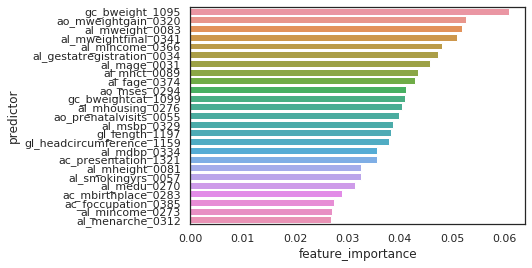

In [55]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [56]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.606
Brier loss: 0.025


##### Random forest

In [57]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.602
Brier loss: 0.026


##### Neural net

In [58]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [59]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6280 y_train n=6280 x_test n=9243 y_test n=9243
Train on 6280 samples
Epoch 1/30
6280/6280 [==============================] - 1s 137us/sample - loss: 2.5002 - AUC: 0.5417
Epoch 2/30
6280/6280 [==============================] - 0s 59us/sample - loss: 0.3889 - AUC: 0.5230
Epoch 3/30
6280/6280 [==============================] - 0s 65us/sample - loss: 0.7080 - AUC: 0.5106
Epoch 4/30
6280/6280 [==============================] - 0s 70us/sample - loss: 0.2147 - AUC: 0.5472
Epoch 5/30
6280/6280 [==============================] - 0s 64us/sample - loss: 0.7473 - AUC: 0.5200
Epoch 6/30
6280/6280 [==============================] - 0s 74us/sample - loss: 0.3779 - AUC: 0.5494
Epoch 7/30
6280/6280 [==============================] - 0s 70us/sample - loss: 0.3010 - AUC: 0.5150
Epoch 8/30
6280/6280 [==============================] - 0s 68us/sample - loss: 0.3449 - AUC: 0.5626
Epoch 9/30
6280/6280 [==============================] - 0s 66us/sample - loss: 0.2968 - AUC: 0.5722
Epoch 10/30
6280/62

## Resus

##### Feature selection

In [60]:
# split out data
train_x, train_y = split_data(train, antenatal_growth, '_resus')
test_x, test_y = split_data(test, antenatal_growth, '_resus')

In [61]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

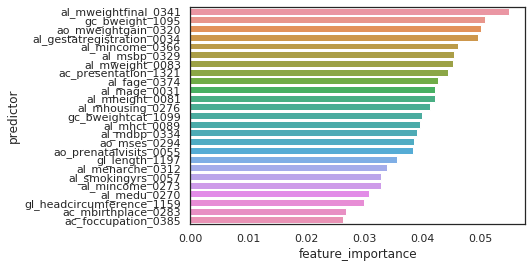

In [62]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [63]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.592
Brier loss: 0.051


##### Random forest

In [64]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.587
Brier loss: 0.053


##### Neural net

In [65]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [66]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=6299 y_train n=6299 x_test n=9253 y_test n=9253
Train on 6299 samples
Epoch 1/30
6299/6299 [==============================] - 1s 136us/sample - loss: 0.9464 - AUC: 0.5359
Epoch 2/30
6299/6299 [==============================] - 0s 70us/sample - loss: 0.6789 - AUC: 0.5215
Epoch 3/30
6299/6299 [==============================] - 0s 66us/sample - loss: 0.8746 - AUC: 0.5185
Epoch 4/30
6299/6299 [==============================] - 0s 65us/sample - loss: 0.4020 - AUC: 0.5427
Epoch 5/30
6299/6299 [==============================] - 0s 63us/sample - loss: 0.6507 - AUC: 0.5371
Epoch 6/30
6299/6299 [==============================] - 0s 70us/sample - loss: 0.5265 - AUC: 0.5258
Epoch 7/30
6299/6299 [==============================] - 0s 68us/sample - loss: 1.1215 - AUC: 0.5107
Epoch 8/30
6299/6299 [==============================] - 0s 65us/sample - loss: 0.7416 - AUC: 0.5310
Epoch 9/30
6299/6299 [==============================] - 0s 65us/sample - loss: 0.3488 - AUC: 0.5567
Epoch 10/30
6299/62

### Antenatal and intrapartum

#### HIE

##### Feature selection

In [67]:
# split out data
train_x, train_y = split_data(train, antenatal_intrapartum, '_hie')
test_x, test_y = split_data(test, antenatal_intrapartum, '_hie')

In [68]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

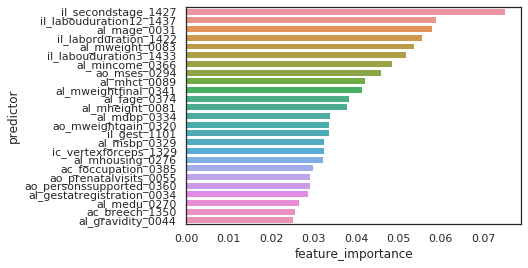

In [69]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [70]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.636
Brier loss: 0.004


##### Random forest

In [71]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.617
Brier loss: 0.004


##### Neural net

In [72]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [73]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=5867 y_train n=5867 x_test n=8319 y_test n=8319
Train on 5867 samples
Epoch 1/30
5867/5867 [==============================] - 1s 173us/sample - loss: 0.0406 - AUC: 0.5533
Epoch 2/30
5867/5867 [==============================] - 0s 66us/sample - loss: 0.0351 - AUC: 0.5765
Epoch 3/30
5867/5867 [==============================] - 0s 69us/sample - loss: 0.0344 - AUC: 0.6810
Epoch 4/30
5867/5867 [==============================] - 0s 69us/sample - loss: 0.0324 - AUC: 0.6832
Epoch 5/30
5867/5867 [==============================] - 0s 72us/sample - loss: 0.0304 - AUC: 0.7660
Epoch 6/30
5867/5867 [==============================] - 0s 66us/sample - loss: 0.0300 - AUC: 0.7713
Epoch 7/30
5867/5867 [==============================] - 0s 68us/sample - loss: 0.0293 - AUC: 0.7849
Epoch 8/30
5867/5867 [==============================] - 0s 65us/sample - loss: 0.0280 - AUC: 0.8085
Epoch 9/30
5867/5867 [==============================] - 0s 63us/sample - loss: 0.0272 - AUC: 0.8407
Epoch 10/30
5867/58

## Perinatal Death

##### Feature selection

In [74]:
# split out data
train_x, train_y = split_data(train, antenatal_intrapartum, '_perinataldeath')
test_x, test_y = split_data(test, antenatal_intrapartum, '_perinataldeath')

In [75]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

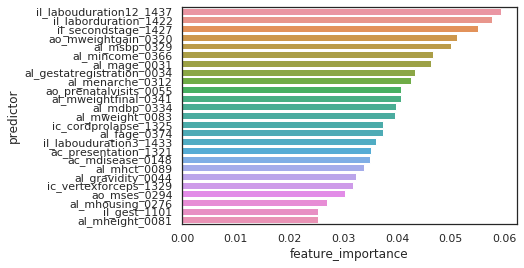

In [76]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [77]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.561
Brier loss: 0.007


##### Random forest

In [78]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.543
Brier loss: 0.006


##### Neural net

In [79]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [80]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=5896 y_train n=5896 x_test n=8335 y_test n=8335
Train on 5896 samples
Epoch 1/30
5896/5896 [==============================] - 1s 168us/sample - loss: 0.4742 - AUC: 0.5541
Epoch 2/30
5896/5896 [==============================] - 0s 68us/sample - loss: 0.0487 - AUC: 0.6019
Epoch 3/30
5896/5896 [==============================] - 0s 66us/sample - loss: 0.0496 - AUC: 0.6151
Epoch 4/30
5896/5896 [==============================] - 0s 72us/sample - loss: 0.0392 - AUC: 0.7114
Epoch 5/30
5896/5896 [==============================] - 0s 67us/sample - loss: 0.0626 - AUC: 0.5522
Epoch 6/30
5896/5896 [==============================] - 0s 70us/sample - loss: 0.0468 - AUC: 0.6732
Epoch 7/30
5896/5896 [==============================] - 0s 67us/sample - loss: 0.0434 - AUC: 0.6426
Epoch 8/30
5896/5896 [==============================] - 0s 63us/sample - loss: 0.0533 - AUC: 0.6105
Epoch 9/30
5896/5896 [==============================] - 0s 62us/sample - loss: 0.0436 - AUC: 0.6192
Epoch 10/30
5896/58

## Low Apgar

##### Feature selection

In [81]:
# split out data
train_x, train_y = split_data(train, antenatal_intrapartum, '_lapgar')
test_x, test_y = split_data(test, antenatal_intrapartum, '_lapgar')

In [82]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

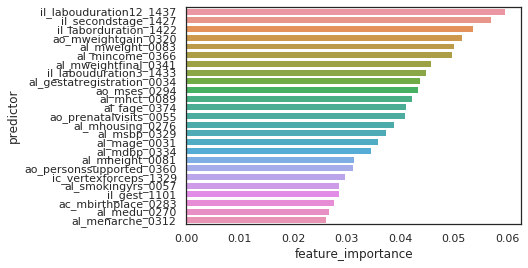

In [83]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [84]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.637
Brier loss: 0.025


##### Random forest

In [85]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.603
Brier loss: 0.025


##### Neural net

In [86]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [87]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=5867 y_train n=5867 x_test n=8319 y_test n=8319
Train on 5867 samples
Epoch 1/30
5867/5867 [==============================] - 1s 166us/sample - loss: 0.3400 - AUC: 0.5509
Epoch 2/30
5867/5867 [==============================] - 0s 64us/sample - loss: 0.1431 - AUC: 0.5556
Epoch 3/30
5867/5867 [==============================] - 0s 65us/sample - loss: 0.1380 - AUC: 0.5838
Epoch 4/30
5867/5867 [==============================] - 0s 69us/sample - loss: 0.1366 - AUC: 0.5958
Epoch 5/30
5867/5867 [==============================] - 0s 66us/sample - loss: 0.1344 - AUC: 0.6177
Epoch 6/30
5867/5867 [==============================] - 0s 63us/sample - loss: 0.1337 - AUC: 0.6244
Epoch 7/30
5867/5867 [==============================] - 0s 72us/sample - loss: 0.1334 - AUC: 0.6228
Epoch 8/30
5867/5867 [==============================] - 0s 72us/sample - loss: 0.1323 - AUC: 0.6441
Epoch 9/30
5867/5867 [==============================] - 0s 64us/sample - loss: 0.1304 - AUC: 0.6568
Epoch 10/30
5867/58

## Resus

##### Feature selection

In [88]:
# split out data
train_x, train_y = split_data(train, antenatal_intrapartum, '_resus')
test_x, test_y = split_data(test, antenatal_intrapartum, '_resus')

In [89]:
# Recursive feature elimination using Random Forest classifier
train_x, train_y, test_x, test_y = recursive_feature_elimination_rf(train_x, train_y, test_x, test_y)

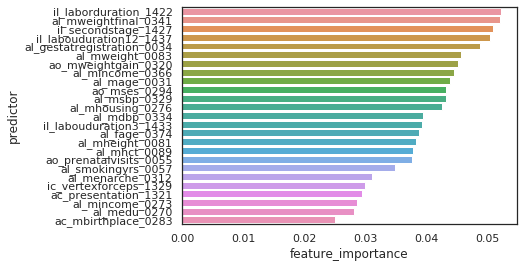

In [90]:
# plot top feature importance measures for variables that contribute to the model
fi = get_feature_importance(train_x, train_y)
ax = sns.barplot(y='predictor', x="feature_importance", data=fi.sort_values('feature_importance', ascending=False)) 

##### Logistic regression

In [91]:
# evaluate model
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=100000)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.644
Brier loss: 0.049


##### Random forest

In [92]:
# evaluate model
clf = RandomForestClassifier(random_state=0, n_estimators=100)
y_test_pred = fit(clf, train_x, train_y, test_x, test_y)

ROC AUC: 0.598
Brier loss: 0.05


##### Neural net

In [93]:
# normalise continuous values
train_x = process_data(train_x, linear, means, stds)
test_x = process_data(test_x, linear, means, stds)

In [94]:
# evaluate model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# fit model
y_test_pred = fit_nn(model, train_x, train_y, test_x, test_y)

x_train n=5896 y_train n=5896 x_test n=8335 y_test n=8335
Train on 5896 samples
Epoch 1/30
5896/5896 [==============================] - 1s 148us/sample - loss: 0.3208 - AUC: 0.4571
Epoch 2/30
5896/5896 [==============================] - 0s 67us/sample - loss: 0.2237 - AUC: 0.5097
Epoch 3/30
5896/5896 [==============================] - 0s 67us/sample - loss: 0.2147 - AUC: 0.5502
Epoch 4/30
5896/5896 [==============================] - 0s 65us/sample - loss: 0.2125 - AUC: 0.5485
Epoch 5/30
5896/5896 [==============================] - 0s 64us/sample - loss: 0.1999 - AUC: 0.5838
Epoch 6/30
5896/5896 [==============================] - 0s 75us/sample - loss: 0.1999 - AUC: 0.5960
Epoch 7/30
5896/5896 [==============================] - 0s 65us/sample - loss: 0.2028 - AUC: 0.5875
Epoch 8/30
5896/5896 [==============================] - 0s 61us/sample - loss: 0.2066 - AUC: 0.5911
Epoch 9/30
5896/5896 [==============================] - 0s 69us/sample - loss: 0.2010 - AUC: 0.6184
Epoch 10/30
5896/58